In [26]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import scipy as sp
from CEA import ThermoProps

Rg = 208.1  # J kg^-1 K^-1
argon_3 = ThermoProps(3)
argon_20 = ThermoProps(20)
c_cp = 522  # J kg^-1 K^-1
c_gamma = 1.67
Km = 0.0504  # s K^0.5 m^-1

cw_power = 350  # W
pulse_power = 3080  # W
pulse_energy = pulse_power*0.01  # J, for 10 ms pulse

room_temp = 290  # K
room_pressure = 1e5  # Pa

sonic_pressure = lambda p0: p0*(2/(c_gamma+1))**(c_gamma/(c_gamma-1))

class Scenario:
    def __init__(self, pressure: float, power: float, label: str, fmt: str):
        self.pc_cold = pressure
        self.power = power
        self.label = label
        self.fmt = fmt

CW = Scenario(20e5, 350, 'CW20', 'C0')
P1 = Scenario(20e5, 3080, 'P20', 'C0-.')
P2 = Scenario(3e5, 3080, 'P3', 'C1:')
scenarios = [CW, P1, P2]

## Model
$$
    F_\mathrm{T} = \dot{m}\sqrt{\frac{2\gamma}{\gamma-1}R_\mathrm{g}T_\mathrm{c}\left(1-\left(\frac{p_\mathrm{e}}{p_\mathrm{c}}\right)^\frac{\gamma-1}{\gamma}\right)} + A_\mathrm{e}(p_\mathrm{e}-p_\mathrm{a})
$$

## Givens
- fixed mass flow rate from choked orifice inlet $\implies \dot{m} \text{ const}$
- choked orifice nozzle (no diverging section) $\implies p_\mathrm{e}=p^*=f(p_\mathrm{c}, \gamma)$
- Exhaust to atmospheric pressure $\implies p_\mathrm{a} =$ 1 bar

## Assumptions
- perfect gas $\implies c_p\text{ const}, \gamma\text{ const}$

## Controlled variables
Mass-flow rate $\dot{m}$, starting chamber pressure $p_\text{c, init}$ (two cases)

## Some relations
For a set mass flow rate and chamber pressure, for cold-flow conditions, the exhaust nozzle diameter is fully constrained:
$$
    \dot{m} = K_{\dot{m}}A_\mathrm{e}\frac{p_\mathrm{c}}{\sqrt{T_\mathrm{a}}}
    \implies A_\mathrm{e} = \frac{\dot{m}}{K_{\dot{m}}}\frac{\sqrt{T_\mathrm{a}}}{p_\mathrm{c}}
$$

In [27]:
def nozzle_area(mdot, pc):
    return mdot*np.sqrt(room_temp)/(Km*pc)

def exit_velocity(Tc, pc, pe):
    A = 2*c_gamma/(c_gamma-1)
    B = Rg*Tc
    C = 1-(pe/pc)**((c_gamma-1)/c_gamma)
    return np.sqrt(A*B*C)

def pressure_thrust(Ae, pe):
    return Ae*(pe-room_pressure)

def thrust_characteristics(mdot, ve, pressure_thrust):
    '''Returns the thrust and equivalent exhaust velocity'''
    return mdot*ve+pressure_thrust, ve+pressure_thrust/mdot

vtoIsp = lambda v: v/9.81
Isptov = lambda isp: 9.81*isp

def plot_thrust(mdot, thrust, func=plt.loglog, noaxlabel=False, **kwargs):
    func(mdot*1000, thrust, **kwargs)
    ax = plt.gca()
    if not ax.get_ylabel() and not noaxlabel:
        ax.set_xlabel(r'Mass-flow rate $\dot{m}$ [g s$^{-1}$]')
        ax.set_ylabel(r'Thrust $F_\mathrm{T}$ [N]')

def plot_exhaust_vel(mdot, velocity, func=plt.loglog, noaxlabel=False, **kwargs):
    func(mdot*1000, velocity, **kwargs)
    ax = plt.gca()
    if not ax.get_ylabel() and not noaxlabel:
        ax.set_xlabel(r'Mass-flow rate $\dot{m}$ [g s$^{-1}$]')
        ax.set_ylabel(r'Exhaust velocity $v_\mathrm{ex}$ [m s$^{-1}$]')
        ax2 = ax.secondary_yaxis('right', functions=(vtoIsp, Isptov))
        ax2.set_ylabel(r'Specific impulse $I_\mathrm{sp}$ [m s$^{-1}$]')



# Initial conditions
Starting the thruster in cold-flow conditions. What's the thrust and exhaust velocity for a range of mass-flow rates?

Scenario CW20:
Exit velocity: 274.8 m/s
Equivalent exhaust velocity: 422.3 m/s
Equivalent Isp: 43.0 s

Scenario P20:
Exit velocity: 274.8 m/s
Equivalent exhaust velocity: 422.3 m/s
Equivalent Isp: 43.0 s

Scenario P3:
Exit velocity: 274.8 m/s
Equivalent exhaust velocity: 326.6 m/s
Equivalent Isp: 33.3 s



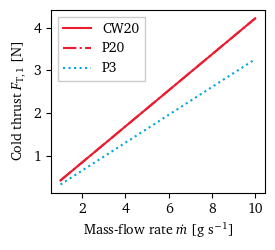

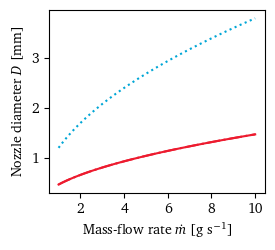

In [28]:
start_pressures = [20e5, 3e5]  # Pa
mdot = np.linspace(1,10)/1000  # kg s^-1

fig, axes = plt.subplots(figsize=(2.85,2.6))
fig_nozzle, axes_nozzle = plt.subplots(figsize=(2.85,2.6))
for s in scenarios:
    s.Ae = nozzle_area(mdot, s.pc_cold)
    nozzle_diameter = np.sqrt(4*s.Ae/np.pi)*1000
    axes_nozzle.plot(mdot*1000, nozzle_diameter, s.fmt, label=s.label)
    s.pe_cold = sonic_pressure(s.pc_cold)
    s.ve_cold = exit_velocity(room_temp, s.pc_cold, s.pe_cold)
    s.FTp_cold = pressure_thrust(s.Ae, s.pe_cold)
    s.FT_cold, ve_eq = thrust_characteristics(mdot, s.ve_cold, s.FTp_cold)
    s.veq_cold = ve_eq[0]
    axes.plot(mdot*1000, s.FT_cold, s.fmt, label=s.label)
    print('Scenario '+s.label+':')
    print('Exit velocity: {:.1f} m/s'.format(s.ve_cold))
    print('Equivalent exhaust velocity: {:.1f} m/s'.format(s.veq_cold))
    print('Equivalent Isp: {:.1f} s\n'.format(vtoIsp(s.veq_cold)))
axes.set_xlabel(r'Mass-flow rate $\dot{m}$ [g s$^{-1}$]')
axes.set_ylabel(r'Cold thrust $F_{\mathrm{T,}1}$ [N]')
axes_nozzle.set_xlabel(r'Mass-flow rate $\dot{m}$ [g s$^{-1}$]')
axes_nozzle.set_ylabel(r'Nozzle diameter $D$ [mm]')
axes.legend()
# plt.grid(which='both', axis='y')
# plt.grid(which='major', axis='x')
fig.tight_layout()
fig_nozzle.tight_layout()
fig.savefig('../report/assets/4 models/cold_thrust.pdf')
fig_nozzle.savefig('../report/assets/4 models/cold_thrust_nozzle.pdf')

# Adding heat
We're adding 350 W of heat for the 20 bar case, and 3080 W for the 3 bar case:
$$
    T_\mathrm{c} = T_\mathrm{a} + \frac{Q_\mathrm{in}}{\dot{m}c_p}
$$
Once the thruster transitions to hot-fire conditions, i.e., $T_\mathrm{a} \rightarrow T_\mathrm{c}$, since the mass-flow rate is still fixed and the nozzle can no longer be changed, the chamber pressure will increase with the square-root of the chamber temperature:
$$
    p_\mathrm{c} = \frac{\dot{m}\sqrt{T_\mathrm{c}}}{K_{\dot{m}}A_\mathrm{e}}
$$

In [29]:

def chamber_temperature(mdot, Qin):
    return Qin/(mdot*c_cp)

def chamber_pressure(mdot, Tc, Ae):
    return (mdot*np.sqrt(Tc))/(Km*Ae)

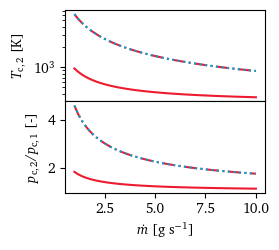

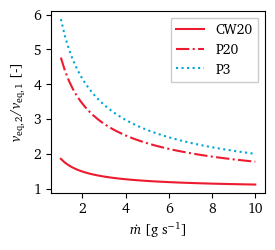

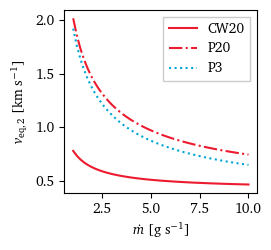

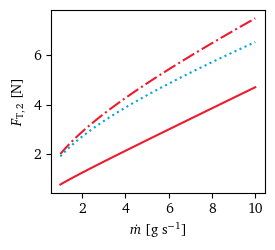

In [30]:
fig1, axes1 = plt.subplots(2, 1, sharex=True, figsize=(2.85,2.6))
fig2, axes2 = plt.subplots(sharex=True, figsize=(2.85,2.6))
fig3 ,axes3 = plt.subplots(figsize=(2.85,2.6))
fig4 ,ax_FT = plt.subplots(figsize=(2.85,2.6))
ax_Tc, ax_pc = axes1
# ax_FT, ax_ve = axes2
ax_veratio = axes2
for s in scenarios:
    s.Tc_hot = room_temp + s.power/(mdot*c_cp)
    ax_Tc.semilogy(mdot*1000, s.Tc_hot, s.fmt, label=s.label)
    s.pc_hot = chamber_pressure(mdot, s.Tc_hot, s.Ae)
    ax_pc.plot(mdot*1000, s.pc_hot/s.pc_cold, s.fmt, label=s.label)
    s.pe_hot = sonic_pressure(s.pc_hot)
    s.ve_hot = exit_velocity(s.Tc_hot, s.pc_hot, s.pe_hot)
    s.FTp_hot = pressure_thrust(s.Ae, s.pe_hot)
    s.FT_hot, s.veq_hot = thrust_characteristics(mdot, s.ve_hot, s.FTp_hot)
    ax_FT.plot(mdot*1000, s.FT_hot, s.fmt, label=s.label)
    axes3.plot(mdot*1000, s.veq_hot/1000, s.fmt, label=s.label)
    ax_veratio.plot(mdot*1000, s.veq_hot/s.veq_cold, s.fmt, label=s.label)
ax_Tc.set_ylabel(r'$T_{\mathrm{c,}2}$ [K]')
ax_FT.set_ylabel(r'$F_{\mathrm{T,}2}$ [N]')
ax_FT.set_xlabel(r'$\dot{m}$ [g s$^{-1}$]')
ax_pc.set_ylabel(r'$p_{\mathrm{c,}2}/p_{\mathrm{c,}1}$ [-]')
ax_pc.set_xlabel(r'$\dot{m}$ [g s$^{-1}$]')
ax_veratio.legend()
ax_veratio.set_ylabel(r'$v_{\mathrm{eq,}2}/v_{\mathrm{eq,}1}$ [-]')
ax_veratio.set_xlabel(r'$\dot{m}$ [g s$^{-1}$]')
axes3.set_ylabel(r'$v_{\mathrm{eq,}2}$ [km s$^{-1}$]')
axes3.legend()
# axes3_2 = axes3.secondary_yaxis('right', functions=(vtoIsp, Isptov))
# axes3_2.set_ylabel(r'$I_{\mathrm{sp,}2}$ [s]')
axes3.set_xlabel(r'$\dot{m}$ [g s$^{-1}$]')
fig1.tight_layout()
fig1.subplots_adjust(hspace=0)
fig2.tight_layout()
fig3.tight_layout()
fig4.tight_layout()

fig1.savefig('../report/assets/4 models/thermo_hotThrust.pdf')
fig2.savefig('../report/assets/4 models/veRatio_hotThrust.pdf')
fig3.savefig('../report/assets/4 models/ve_hotThrust.pdf')
fig4.savefig('../report/assets/4 models/thrust_hotThrust.pdf')